# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os
import re

from joblib import Parallel, delayed
import kmermaid_utils
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import sig_utils
import sourmash
from tqdm import tqdm

pd.options.display.max_colwidth = 500
pd.options.display.max_columns = 50

from sourmash_search_utils import read_and_process_sourmash_search_results

## Constants (ksizes, scaled)

In [2]:
ls -lha /home/olga/data_sm/immune-evolution/kmer-signatures

total 11K
drwxr-xr-x  7 olga czb 4.0K Mar  5 12:02 ./
drwxrwxr-x 81 olga czb 8.0K Feb 28 09:02 ../
drwxr-xr-x  4 olga czb 4.0K Feb 28 09:53 0--mouse2mouse/
drwxr-xr-x  7 olga czb 4.0K Feb 28 16:57 1--train-mouse/
drwxr-xr-x  8 olga czb 4.0K Mar  3 14:50 2--test-human/
drwxr-xr-x  8 olga czb 4.0K Mar  5 11:57 3--test-bat/
drwxr-xr-x  7 olga czb 4.0K Mar  3 14:45 4--test-lemur/


In [3]:
sig_outdir_base = '/home/olga/data_sm/immune-evolution/kmer-signatures'

lemur_test_dir = os.path.join(sig_outdir_base, "4--test-lemur")

aggregated_results_dir = os.path.join(lemur_test_dir, '4--aggregated-results')
! mkdir -p $aggregated_results_dir

In [4]:
SHARED_CELLTYPES = set(['Alveolar Epithelial Type 2',
 'B cell',
 'Capillary',
 'Dendritic',
 'Fibroblast',
 'Macrophage',
 'Monocyte',
 'Natural Killer T cell',
 'Smooth Muscle and Myofibroblast',
 'T cell'])
SHARED_CELLTYPES

{'Alveolar Epithelial Type 2',
 'B cell',
 'Capillary',
 'Dendritic',
 'Fibroblast',
 'Macrophage',
 'Monocyte',
 'Natural Killer T cell',
 'Smooth Muscle and Myofibroblast',
 'T cell'}

## Def describe

In [5]:
def describe(df, random=False):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    if random:
        print('--- Random subset ---')
        display(df.sample(5))

### Remove rogue TQDM instances

In [6]:
def remove_rogue_tqdm():
    import tqdm
    try:
        tqdm._instances.clear()
    except AttributeError:
        pass

## Read one2one 5had

In [7]:
one2one = sc.read(
#     "/home/phoenix/data_sm/code/immune-evolution/h5ads/human-lemur-mouse-bat__lung_only_copy.h5ad"
    "/home/olga/data_sm/immune-evolution/h5ads/human-lemur-mouse-bat/human-lemur-mouse-bat__lung_only.h5ad"
)
one2one.obs = one2one.obs.reset_index().set_index('cell_id')

one2one.obs.head()

,index,age,cell_barcode,cell_ontology_class,cell_ontology_id,channel,free_annotation,individual,sample,sequencing_run,sex,species,species_batch,species_latin,tissue,narrow_group,broad_group,compartment_group,compartment_narrow,channel_cleaned,batch,n_genes,n_counts,species_batch_v2,compartment_broad,compartment_broad_narrow,compartment_species,compartment_narrow_species,common_individual_id
cell_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P2_1__AAACCTGAGAAACCAT,P2_1_AAACCTGAGAAACCAT-human-hlm,46y,AAACCTGAGAAACCAT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,male,Human,human,Homo sapiens,Lung,Capillary Aerocyte,Capillary,endothelial,endothelial: Capillary Aerocyte,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AAATGCCAGATGAGAG,P2_1_AAATGCCAGATGAGAG-human-hlm,46y,AAATGCCAGATGAGAG,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,male,Human,human,Homo sapiens,Lung,Capillary Aerocyte,Capillary,endothelial,endothelial: Capillary Aerocyte,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACACGTTCGATCCCT,P2_1_AACACGTTCGATCCCT-human-hlm,46y,AACACGTTCGATCCCT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,male,Human,human,Homo sapiens,Lung,Capillary Aerocyte,Capillary,endothelial,endothelial: Capillary Aerocyte,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACACGTTCGCACTCT,P2_1_AACACGTTCGCACTCT-human-hlm,46y,AACACGTTCGCACTCT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,male,Human,human,Homo sapiens,Lung,Capillary Aerocyte,Capillary,endothelial,endothelial: Capillary Aerocyte,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACCATGCAGCTCGCA,P2_1_AACCATGCAGCTCGCA-human-hlm,46y,AACCATGCAGCTCGCA,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,male,Human,human,Homo sapiens,Lung,Capillary Aerocyte,Capillary,endothelial,endothelial: Capillary Aerocyte,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2


# Analyze Sourmash search

## Functions / tools to add cell type ontologies

## Search directory output

### Column renamer

## Read output CSVs -- Parallelized

In [9]:
# from sourmash_search_utils import read_and_process_sourmash_search_results


# bat_kmermaid_base = (
#     "/home/olga/data_sm/immune-evolution/pipeline-results/bat/kmermaid/ksize_8"
# )
# bat_search_dir = os.path.join(
#     bat_kmermaid_base,
#     "search_bat_in_mouse_no_ribosome_no_containment_no_dissociation__per_celltype_remove_common_hashes__remove_refseq_ribosomal",
# #     "search_bat_in_mouse_no_ribosome_no_containment_no_dissociation__per_celltype_remove_common_hashes",
# )

# total = 612648

# globber = os.path.join(bat_search_dir, "alphabet-dayhoff__ksize-39__scaled-10", "*.csv")

# # dfs = Parallel(n_jobs=96)(
# #     delayed(read_and_process_sourmash_search_results)(
# #         csv, adata=one2one, column_renamer=bat_renamer, query_species='bat'
# #     )
# #     for csv in tqdm(glob.iglob(globber), total=total)
# # )

# # search_results = pd.concat(dfs, ignore_index=True)
# # print(search_results.shape)
# # search_results.head()

In [10]:
from sourmash_search_utils import add_ontologies

## Read output CSVs

In [53]:
dfs = []

globber = os.path.join(lemur_test_dir, "3-*", "*", "*.csv")

total = sum(1 for _ in glob.iglob(globber))


query_species = "lemur"

cols = ["cell_ontology_class", "narrow_group", "broad_group", "compartment_group"]

query_renamer = {col: f"{query_species}_{col}" for col in cols}



for csv in tqdm(glob.iglob(globber), total=total):
    df = read_and_process_sourmash_search_results(
        csv,
        adata=one2one,
        column_renamer=query_renamer,
        query_species=query_species,
        shared_celltypes=SHARED_CELLTYPES,
    )

    df["database_type"] = os.path.dirname(csv).split("/")[-2].split("--")[-1]

    dfs.append(df)
#     break
search_results = pd.concat(dfs, ignore_index=True)
print(search_results.shape)
search_results.head()

100%|██████████| 100652/100652 [1:50:32<00:00, 15.18it/s] 


(1006422, 16)


,similarity,mouse_broad_group,search_method,sketch_id,lemur_cell_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,lemur_channel,lemur_cell_ontology_class,lemur_narrow_group,lemur_broad_group,lemur_compartment_group,database_type
0,0.146105,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,ANTOINE_LUNG_EPCAM__CCAATCCAGACTACAA,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_EPCAM,monocyte,Monocyte,Monocyte,myeloid,min-5-percent-shared-kmers
1,0.139129,Monocyte,containment,alphabet-dayhoff__ksize-51__scaled-10,ANTOINE_LUNG_EPCAM__CCAATCCAGACTACAA,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_EPCAM,monocyte,Monocyte,Monocyte,myeloid,min-5-percent-shared-kmers
2,0.117556,T cell,containment,alphabet-dayhoff__ksize-51__scaled-10,ANTOINE_LUNG_EPCAM__CCAATCCAGACTACAA,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_EPCAM,monocyte,Monocyte,Monocyte,myeloid,min-5-percent-shared-kmers
3,0.114326,Natural Killer T cell,containment,alphabet-dayhoff__ksize-51__scaled-10,ANTOINE_LUNG_EPCAM__CCAATCCAGACTACAA,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_EPCAM,monocyte,Monocyte,Monocyte,myeloid,min-5-percent-shared-kmers
4,0.113810,Alveolar Epithelial Type 2,containment,alphabet-dayhoff__ksize-51__scaled-10,ANTOINE_LUNG_EPCAM__CCAATCCAGACTACAA,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_EPCAM,monocyte,Monocyte,Monocyte,myeloid,min-5-percent-shared-kmers


In [67]:
n_results_per_sketch_id = search_results.groupby(['sketch_id', 'alphabet', 'ksize', 'search_method']).size()
n_results_per_sketch_id.name = 'n_results'
n_results_per_sketch_id = n_results_per_sketch_id.reset_index()
describe(n_results_per_sketch_id)

(6, 5)
--- First 5 entries ---


,sketch_id,alphabet,ksize,search_method,n_results
0,alphabet-DNA__ksize-21__scaled-10,DNA,21,containment,14160
1,alphabet-DNA__ksize-21__scaled-10,DNA,21,similarity_abundance,14160
2,alphabet-dayhoff__ksize-51__scaled-10,dayhoff,51,containment,195640
3,alphabet-dayhoff__ksize-51__scaled-10,dayhoff,51,similarity_abundance,293434
4,alphabet-protein__ksize-30__scaled-10,protein,30,containment,195640


In [55]:
n_results_per_sketch_id.nlargest(5, 'n_results')

,sketch_id,alphabet,ksize,n_results
1,alphabet-dayhoff__ksize-51__scaled-10,dayhoff,51,489074
2,alphabet-protein__ksize-30__scaled-10,protein,30,489028
0,alphabet-DNA__ksize-21__scaled-10,DNA,21,28320


In [56]:
n_results_per_sketch_id.loc[n_results_per_sketch_id.n_results.argmax()]

sketch_id    alphabet-dayhoff__ksize-51__scaled-10
alphabet                                   dayhoff
ksize                                           51
n_results                                   489074
Name: 1, dtype: object

## Constants (`classification_groupby`, `celltype_col`, `query_organism`, `scoring_groupby`)

In [58]:
celltype_col = "broad_group"
sbt_organism = "mouse"
query_organism = "lemur"

classification_groupby = [
    f"{query_organism}_cell_id",
    "database_type",
    "search_method",
    "alphabet",
    "ksize",
]

predicted_celltype_col = f"{sbt_organism}_{celltype_col}"
ground_truth_celltype_col = f"{query_organism}_{celltype_col}"

scoring_groupby = ["database_type", "search_method", "alphabet", "ksize"]

## Add unifying column of predicted and ground truth celltypes

In [59]:
search_results['groundtruth_celltype'] = search_results[ground_truth_celltype_col]
search_results['predicted_celltype'] = search_results[predicted_celltype_col]

# write results to parquet file

In [60]:
%%time

parquet_fn = "sourmash-search-results.parquet"
parquet = os.path.join(aggregated_results_dir, parquet_fn)
search_results.to_parquet(parquet)

parquet

CPU times: user 1.66 s, sys: 164 ms, total: 1.82 s
Wall time: 2.03 s


'/home/olga/data_sm/immune-evolution/kmer-signatures/4--test-lemur/4--aggregated-results/sourmash-search-results.parquet'

# Predict cell type with top hit

## Get top N

In [68]:
%%time

predicted_cells_top_hit = search_results.groupby(
    classification_groupby, as_index=False, group_keys=False
).apply(lambda x: x.nlargest(1, 'similarity'))

predicted_cells_top_hit = predicted_cells_top_hit.set_index(f"{query_organism}_cell_id")

print(predicted_cells_top_hit.shape)
predicted_cells_top_hit.head()

(100652, 17)
CPU times: user 7min 28s, sys: 12.3 s, total: 7min 41s
Wall time: 7min 37s


,similarity,mouse_broad_group,search_method,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,lemur_channel,lemur_cell_ontology_class,lemur_narrow_group,lemur_broad_group,lemur_compartment_group,database_type,groundtruth_celltype,predicted_celltype
lemur_cell_id,,,,,,,,,,,,,,,,,
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.114944,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.110182,Dendritic,containment,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.090060,Macrophage,similarity_abundance,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Macrophage
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.013232,Macrophage,similarity_abundance,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Macrophage
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.044129,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers-remove-common-kmers,Macrophage,Dendritic


### Write top N to file

In [69]:
%%time

parquet_fn = "sourmash-search-results--top-hit.parquet"
parquet = os.path.join(aggregated_results_dir, parquet_fn)
predicted_cells_top_hit.to_parquet(parquet)

CPU times: user 414 ms, sys: 20.2 ms, total: 434 ms
Wall time: 480 ms


In [66]:
1+1

2

# Get ideal ksizes per alphabet sizes

In [63]:
alphabet_sizes = pd.Series(dict(dayhoff=6, protein=20, hp=2))
np.log10(alphabet_sizes.pow(21/3))

dayhoff    5.447059
protein    9.107210
hp         2.107210
dtype: float64

In [64]:
np.log10(alphabet_sizes.pow(27/3))

dayhoff     7.003361
protein    11.709270
hp          2.709270
dtype: float64

In [65]:
np.log10(alphabet_sizes.pow(60/3))

dayhoff    15.563025
protein    26.020600
hp          6.020600
dtype: float64

In [50]:
np.log10(alphabet_sizes.pow(63/3))

dayhoff    16.341176
protein    27.321630
hp          6.321630
dtype: float64

In [51]:
21/3 * np.log10(alphabet_sizes)

dayhoff    5.447059
protein    9.107210
hp         2.107210
dtype: float64

In [52]:
k_nuc_sizes = np.arange(21, 91, 3)
k_nuc_sizes

array([21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69,
       72, 75, 78, 81, 84, 87, 90])

In [26]:
k_aa_sizes = k_nuc_sizes/3
k_aa_sizes

array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,
       20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.])

In [27]:
dna_entropy = pd.Series(k_nuc_sizes * np.log10(4), name='entropy', index=k_nuc_sizes)
dna_entropy = dna_entropy.reset_index()
dna_entropy = dna_entropy.rename(columns={'index': 'k_nuc'})
dna_entropy['alphabet'] = 'dna'
describe(dna_entropy)

(24, 3)
--- First 5 entries ---


,k_nuc,entropy,alphabet
0,21,12.64326,dna
1,24,14.44944,dna
2,27,16.25562,dna
3,30,18.06180,dna
4,33,19.86798,dna


In [28]:
aa_nuc_alphabet_sizes = alphabet_sizes.copy()
aa_nuc_alphabet_sizes['dna'] = 4

In [29]:
alphabet_complexity = alphabet_sizes.to_frame().apply(
    lambda x: pd.Series(k_aa_sizes * np.log10(x.iloc[0]), name=x.name), axis=1
)
alphabet_complexity.columns = k_nuc_sizes
alphabet_complexity = alphabet_complexity.unstack().reset_index()
alphabet_complexity = alphabet_complexity.rename(
    columns={"level_0": "k_nuc", "level_1": "alphabet", 0: "entropy"}
)
alphabet_complexity = pd.concat([alphabet_complexity, dna_entropy])
alphabet_complexity["k_aa"] = (alphabet_complexity["k_nuc"] / 3).astype(int)
alphabet_complexity["sigma"] = alphabet_complexity.alphabet.map(aa_nuc_alphabet_sizes)
alphabet_complexity["alphabet_type"] = alphabet_complexity.alphabet.map(
    lambda x: "nuc" if x == "dna" else "aa"
)
alphabet_complexity["alphabet_label"] = alphabet_complexity.apply(
    lambda x: "{alphabet} $|\Sigma_{{{alphabet_type}}}| = {sigma}$".format(**x), axis=1
)
describe(alphabet_complexity)

(96, 7)
--- First 5 entries ---


,k_nuc,alphabet,entropy,k_aa,sigma,alphabet_type,alphabet_label
0,21,dayhoff,5.447059,7,6,aa,dayhoff $|\Sigma_{aa}| = 6$
1,21,protein,9.107210,7,20,aa,protein $|\Sigma_{aa}| = 20$
2,21,hp,2.107210,7,2,aa,hp $|\Sigma_{aa}| = 2$
3,24,dayhoff,6.225210,8,6,aa,dayhoff $|\Sigma_{aa}| = 6$
4,24,protein,10.408240,8,20,aa,protein $|\Sigma_{aa}| = 20$


In [30]:
sorted(alphabet_complexity.alphabet_label.unique())

['dayhoff $|\\Sigma_{aa}| = 6$',
 'dna $|\\Sigma_{nuc}| = 4$',
 'hp $|\\Sigma_{aa}| = 2$',
 'protein $|\\Sigma_{aa}| = 20$']

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


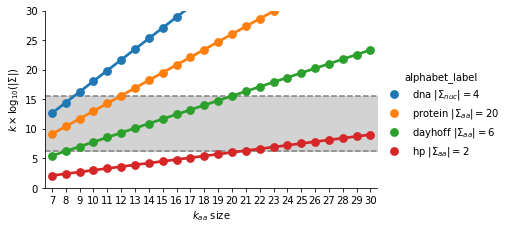

In [31]:
alphabet_order = [
    "dna $|\\Sigma_{nuc}| = 4$",
    "protein $|\\Sigma_{aa}| = 20$",
    "dayhoff $|\\Sigma_{aa}| = 6$",
    "hp $|\\Sigma_{aa}| = 2$",
]

g = sns.catplot(
    x="k_aa",
    data=alphabet_complexity,
    y="entropy",
    hue="alphabet_label",
    kind="point",
    size=3,
    aspect=1.75,
    hue_order=alphabet_order,
)

entropy_min = alphabet_complexity.query(
    'k_nuc == 63 and alphabet == "hp"'
).entropy.iloc[0]
entropy_max = alphabet_complexity.query(
    'k_nuc == 60 and alphabet == "dayhoff"'
).entropy.iloc[0]

for ax in g.axes.flat:
    xmin, xmax = ax.get_xlim()
    ax.fill_between(
        (xmin, xmax), entropy_min, entropy_max, color="lightgrey", zorder=-1
    )
    ax.axhline(entropy_min, color="grey", linestyle="--", zorder=-1)
    ax.axhline(entropy_max, color="grey", linestyle="--", zorder=-1)

g.set(
    ylabel=r"$k \times \log_{10} \left( | \Sigma | \right)$",
    xlim=(xmin, xmax),
    ylim=(0, 30),
    xlabel=r"$k_{aa}$ size",
)
figure_folder = (
    "/home/olga/googledrive/ImmuneEvolution/analysis/alphabet_size_vs_complexity"
)
! mkdir -p $figure_folder
pdf = os.path.join(figure_folder, "alphabet_size_vs_complexity.pdf")
g.savefig(pdf)

In [32]:
alphabet_complexity.query('k_nuc == 39')

,k_nuc,alphabet,entropy,k_aa,sigma,alphabet_type,alphabet_label
18,39,dayhoff,10.115966,13,6,aa,dayhoff $|\Sigma_{aa}| = 6$
19,39,protein,16.913390,13,20,aa,protein $|\Sigma_{aa}| = 20$
20,39,hp,3.913390,13,2,aa,hp $|\Sigma_{aa}| = 2$
6,39,dna,23.480340,13,4,nuc,dna $|\Sigma_{nuc}| = 4$


In [33]:
alphabet_complexity.query('k_nuc == 51')

,k_nuc,alphabet,entropy,k_aa,sigma,alphabet_type,alphabet_label
30,51,dayhoff,13.228571,17,6,aa,dayhoff $|\Sigma_{aa}| = 6$
31,51,protein,22.117510,17,20,aa,protein $|\Sigma_{aa}| = 20$
32,51,hp,5.117510,17,2,aa,hp $|\Sigma_{aa}| = 2$
10,51,dna,30.705060,17,4,nuc,dna $|\Sigma_{nuc}| = 4$
